## Retail Trade Sales

### Data Cleaning and Wrangling

In [36]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
from pytrends.request import TrendReq
import json
import matplotlib

In [27]:
# Reading file

retailsales=pd.read_csv('../../data/retailsalesbyIndustry/retailSalesbyIndustry.csv')

In [28]:
# Renaming columns as per required
retailsales.rename(columns = {'REF_DATE':'DATE', 
                                            'GEO':'LOCATION',
                                            'North American Industry Classification System (NAICS)':'INDUSTRY',
                                            'Adjustments':'ADJUSTMENTS'
                                           },inplace = True)

In [29]:
# Filtering columns as needed and extracting required columns
retailsales_filtered=retailsales[(retailsales['LOCATION'] == 'Canada') & 
                 (retailsales['INDUSTRY'] == 'Retail trade [44-45]')&
                 (retailsales['ADJUSTMENTS'] == 'Seasonally adjusted')&
                 (retailsales['DATE'] >= '2004-01')]
retailsales_final = retailsales_filtered[['DATE', 'VALUE']].copy()

#Changing data type of date
retailsales_final['DATE'] =  pd.to_datetime(retailsales_final['DATE'])
retailsales_final.reset_index(drop=True)

,DATE,VALUE
0,2004-01-01,27935993.0
1,2004-02-01,28719948.0
2,2004-03-01,28689514.0
3,2004-04-01,28254086.0
4,2004-05-01,28554094.0
...,...,...
213,2021-10-01,58218955.0
214,2021-11-01,58750669.0
215,2021-12-01,57919779.0
216,2022-01-01,59857374.0


In [30]:
# plot

# retailsales_date=retailsales_final.set_index('DATE')

# plt.plot(retailsales_date)
# plt.show()

In [31]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

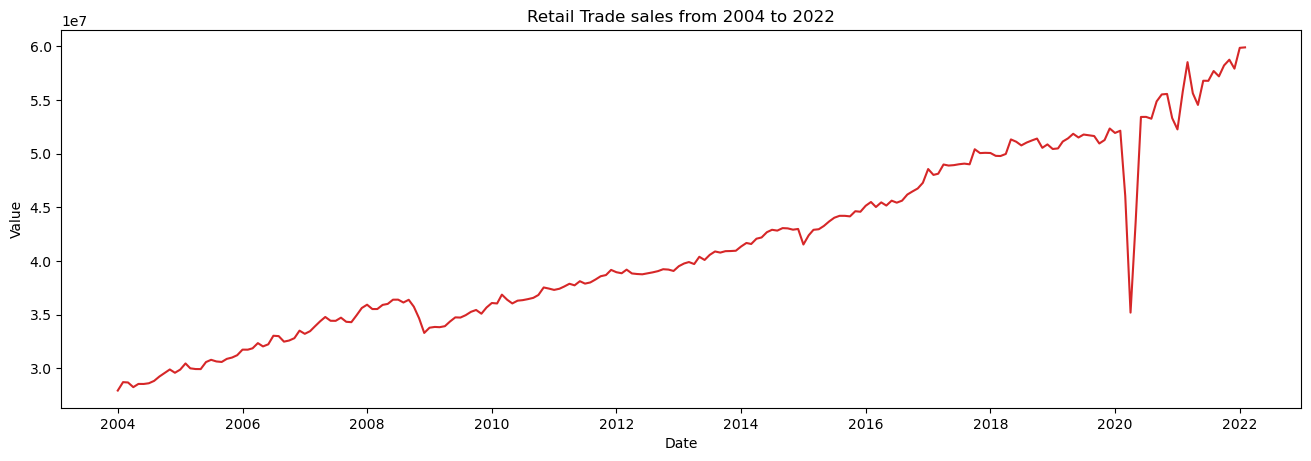

In [32]:
plot_df(retailsales_final, 
        x=retailsales_final.DATE, 
        y=retailsales_final.VALUE, 
        title='Retail Trade sales from 2004 to 2022')    

### Cleaning and using Time Series Data

#### Adding column for growth rate

In [43]:
retailsales_final['GrowthRate']=retailsales_final['VALUE'].pct_change()
retailsales_final.reset_index(drop=True)

,DATE,VALUE,GrowthRate
0,2004-01-01,27935993.0,NaN
1,2004-02-01,28719948.0,0.028063
2,2004-03-01,28689514.0,-0.001060
3,2004-04-01,28254086.0,-0.015177
4,2004-05-01,28554094.0,0.010618
...,...,...,...
213,2021-10-01,58218955.0,0.017790
214,2021-11-01,58750669.0,0.009133
215,2021-12-01,57919779.0,-0.014143
216,2022-01-01,59857374.0,0.033453


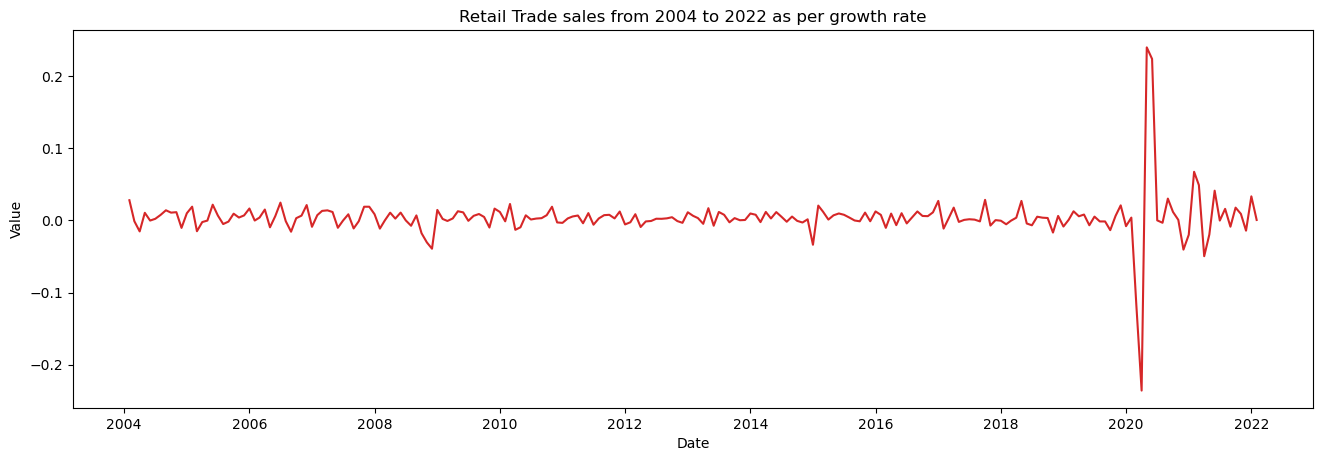

In [44]:
# Plot for growth rate
plot_df(retailsales_final, 
        x=retailsales_final.DATE, 
        y=retailsales_final.GrowthRate, 
        title='Retail Trade sales from 2004 to 2022 as per growth rate') 

In [48]:
from statsmodels.tsa.stattools import adfuller, kpss

result = adfuller(retailsales_final.GrowthRate.values, autolag='AIC')

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(retailsales_final.GrowthRate.values, regression='c')

print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


ADF Statistic: -8.188128969206959
p-value: 7.798833967153268e-13
Critial Values:
   1%, -3.461878735881654
Critial Values:
   5%, -2.875403665910809
Critial Values:
   10%, -2.574159410430839

KPSS Statistic: 0.204782
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/Users/aishwaryasharma/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


## Calculating keywords using Google Trends

In [76]:
# Reading file for Categories
retailcat=pd.read_csv('../../data/keywords_data/RETAIL_SALES.csv')

In [77]:
retailcatdat = retailcat[['CatNo']].copy()

### Function to get the queries, topics and thus keywords using pytrends

In [78]:
pytrends = TrendReq(hl='en-US', tz=360, backoff_factor=0.1)

def get_trend(keyword=[''], category='0'):
    """ Function for getting trends for selected keywords
        
        arguments: 
        
        Keywords: data type is string: stores list of keywords
        category: data type is string: stores the code for category
        
        returns: google trend data, related queries and related topics as a data frame  
    """
    
    kw_list=keyword
    cat=category
    timeframe='2004-01-01 2022-01-01'
    geo ='CA'
    gprop =''
    
    pytrends.build_payload(kw_list, cat, timeframe, geo, gprop)
    data = pytrends.interest_over_time()
    queries = pytrends.related_queries()
    topics = pytrends.related_topics()
    return data, queries, topics

In [79]:
keywordsDictQuery = dict() #Dictionary for queries
keywordsDictTopic = dict() #Dictionary for topic


for index, row in retailcatdat.iterrows():
    
    #Calling function
    data, queries, topics = get_trend(keyword=[''],category=str(row['CatNo']))
    
    
    #Code to append data for different columns in data frame
    
    if index==0:
        FinalData, queries, topics=get_trend(keyword=[''],category=str(row['CatNo']))
        FinalData.rename(columns = {'':str(row['CatNo'])}, inplace = True)
        FinalData=FinalData.drop(columns=['isPartial'])
    else:
        data, queries, topics=get_trend(keyword=[''],category=str(row['CatNo']))
        data.rename(columns = {'':str(row['CatNo'])}, inplace = True)
        data=data.drop(columns=['isPartial'])
        data = data[str(row['CatNo'])]
        FinalData = FinalData.join(data)
    
    #Code to store queries in a dictionary
    queries = queries['']['top']
    top5_query = pd.DataFrame(queries['query'].copy().head(5))
    top5_query = top5_query['query'].values.tolist()  
    keywordsDictQuery[str(row['CatNo'])] = top5_query
    
    #Code to store topics in a dictionary
    topics = topics['']['top']
    top5_topic = pd.DataFrame(topics['topic_title'].copy().head(5))
    top5_topic = top5_topic['topic_title'].values.tolist()
    keywordsDictTopic[str(row['CatNo'])] = top5_topic

In [80]:
FinalData

,841,47,1190,1191,1140,1213,1013,1214,806,810,...,355,1146,18,1225,270,659,1268,38,844,614
date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,49,91,100,51,58,48,86,77,100,90,...,96,38,86,54,90,82,16,91,93,83
2004-02-01,48,89,79,57,57,59,100,90,86,83,...,83,32,82,49,84,89,15,92,100,90
2004-03-01,44,94,63,77,68,64,83,93,89,87,...,91,29,81,51,87,89,23,93,80,86
2004-04-01,47,93,88,93,72,72,91,98,92,91,...,80,32,81,53,79,82,21,93,92,93
2004-05-01,48,95,60,95,74,76,90,89,91,98,...,78,33,80,50,74,81,43,92,89,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,65,44,23,31,35,60,27,68,19,48,...,27,17,47,80,83,38,16,58,30,29
2021-10-01,65,43,23,26,26,47,26,64,18,59,...,24,21,49,83,86,40,26,55,29,37
2021-11-01,70,43,25,24,24,34,26,58,19,64,...,27,25,58,93,91,42,24,60,32,36


### Storing data in data frame

In [82]:
FinalData.to_csv('FinalRetailData.csv')

### Storing queries and topics in json form

In [86]:
#Queries
with open('queries.json', 'w') as fp:
    json.dump(keywordsDictQuery, fp,  indent=4)

In [87]:
#Topics
with open('topics.json', 'w') as fp:
    json.dump(keywordsDictTopic, fp,  indent=4)

In [128]:
# data, queries=get_trend(keyword=[''],category=str(retailcatdat['CatNo'].iloc[0]))
# queries = queries['']['top']
# top5 = pd.DataFrame(queries['query'].copy().head(5))
# top5 = top5['query'].values.tolist()
# keywordsDict = dict()
# keywordsDict[str(retailcatdat['CatNo'].iloc[0])] = top5
# keywordsDict